# Daily Forecast Example

Daily forecast is one of most popular use cases in time-series modeling. In this example, it aims to introduce a way to perform a daily forecast by modeling yearly and weekly seasonality together. We will use the aggregated number of sales from the [M5 competition](https://www.kaggle.com/c/m5-forecasting-accuracy/overview) and Turkish daily electricity demand data from Rob Hyndman's [post](https://robjhyndman.com/publications/complex-seasonality/)

## Example I - M5 Aggregated Sales

In [8]:
import pandas as pd
import numpy as np
import ssl 

from orbit.models.dltcs import DLTCSMAP
from orbit.diagnostics.plot import plot_predicted_data
# to make fourier series for annual seasonality
from orbit.utils.features import make_fourier_series_df

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


For demo purpose, we just use a subset of regressors and perform log transformation on response to construct a multiplicative model.

In [9]:
df = pd.read_csv('./data/m5_agg_demand_full.csv', parse_dates=['date'])
# get a subset of regressor for demo purpose
regressor_col = ["Christmas","Halloween","LaborDay","Thanksgiving","Mother's day","PresidentsDay","NewYear"]

Use the `make_fourier_series_df` to create fourier series features to model dual seasonality.  Then we use the series to capture yearly seasonality.  We will also use `log` (multiplicative model) and division by first observation to perform some pre-processing.

In [10]:
df, fs_cols = make_fourier_series_df(df, 'date', period=365.25, order=3)
# trim data
df = df[["date", "sales"] + fs_cols + regressor_col]
m = df['sales'][0]
df['y'] = np.log(df['sales']/m)

In [11]:
df.head(5)

,date,sales,fs_cos1,fs_sin1,fs_cos2,fs_sin2,fs_cos3,fs_sin3,Christmas,Halloween,LaborDay,Thanksgiving,Mother's day,PresidentsDay,NewYear,y
0,2011-01-29,32631,0.459442,0.888208,0.816160,0.577825,0.990397,0.138250,0,0,0,0,0,0,0,0.000000
1,2011-01-30,31749,0.474653,0.880173,0.835553,0.549409,0.996210,0.086977,0,0,0,0,0,0,0,-0.027402
2,2011-01-31,23783,0.489723,0.871878,0.853958,0.520343,0.999371,0.035473,0,0,0,0,0,0,0,-0.316292
3,2011-02-01,25412,0.504648,0.863325,0.871351,0.490660,0.999870,-0.016127,0,0,0,0,0,0,0,-0.250041
4,2011-02-02,19146,0.519424,0.854517,0.887713,0.460397,0.997707,-0.067683,0,0,0,0,0,0,0,-0.533169


Split the data.

In [12]:
test_size = 28
train_df = df[:-test_size]
test_df = df[-test_size:]

initialize and train the model.

In [13]:
%%time
dlt = DLTCSMAP(
    response_col='y',
    date_col='date',
    seasonality=[7, 365],
    seed=2020,
    regressor_col=fs_cols + regressor_col,
)
dlt._level_update_skip

CPU times: user 187 µs, sys: 6 µs, total: 193 µs
Wall time: 196 µs


In [14]:
dlt.fit(train_df)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_02a1bfc003ceab925372014018a96418 NOW.


predict and plot the result.

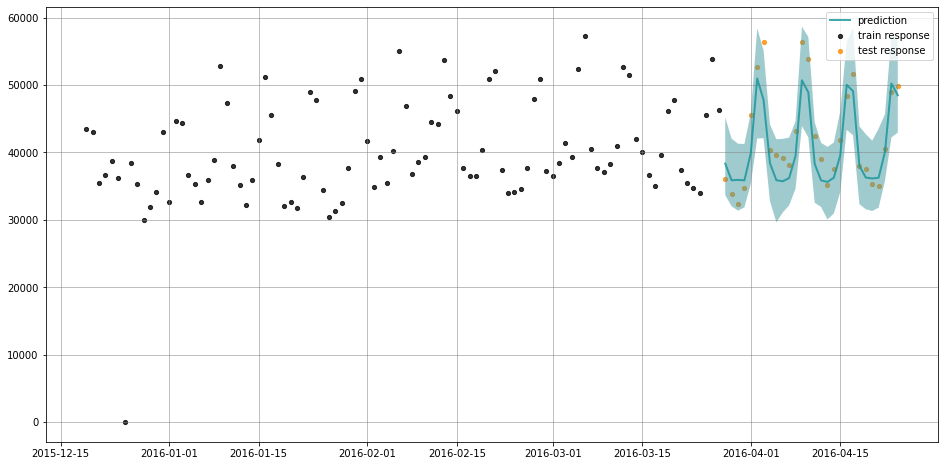

In [7]:
pred_df = dlt.predict(test_df)
pred_df[['prediction_lower', 'prediction', 'prediction_upper']] = \
  pred_df[['prediction_lower', 'prediction', 'prediction_upper']].apply(np.exp) * m
plot_predicted_data(train_df[-100:], pred_df, 'date', 'sales', 'prediction', test_actual_df=test_df)

## Example II - Turkish Daily Electricity
Let's use Turkish daily electricity demand data posted by Rob Hyndman.

In [8]:
ssl._create_default_https_context = ssl._create_unverified_context

# (c) Turkish electricity demand data.
# Daily data from 1 January 2000 to 31 December 2008.
df = pd.read_csv("https://robjhyndman.com/data/turkey_elec.csv", header=None, names=['electricity'])
df['date'] = pd.date_range(start='1/1/2000', end='31/12/2008', freq='D')

In [9]:
df, fs_cols = make_fourier_series_df(df, 'date', 365.25, order=5)
m = df['electricity'][0]
df['y'] = np.log(df['electricity']/m)

Split the data.

In [10]:
test_size = 365
train_df = df[:-test_size]
test_df = df[-test_size:]

initialize and train the model.

In [11]:
%%time
dlt = DLTMAP(
    date_col='date',
    response_col='y',
    regressor_col=fs_cols,
    seasonality=7,
    seed=2020,
)
dlt.fit(train_df)

CPU times: user 3.34 s, sys: 32.1 ms, total: 3.37 s
Wall time: 3.38 s


predict and plot the result.

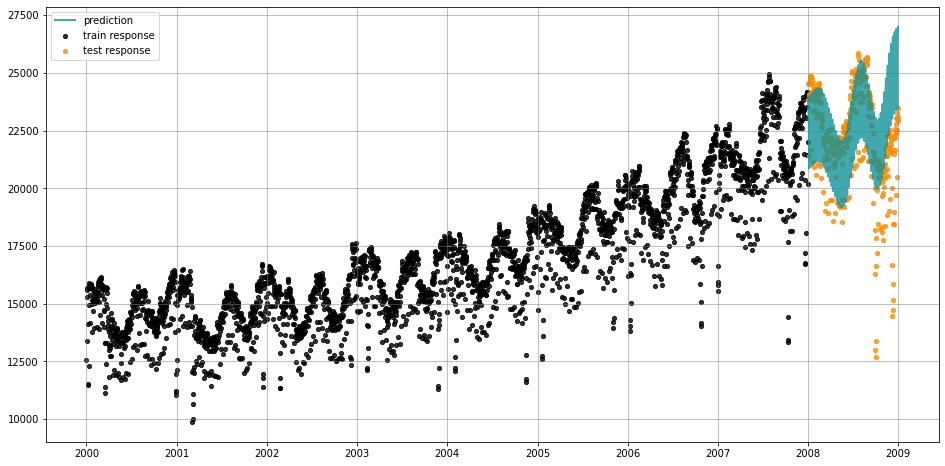

In [12]:
pred_df = dlt.predict(test_df)
pred_df['prediction'] = np.exp(pred_df['prediction']) * m
plot_predicted_data(train_df, pred_df, 'date', 'electricity', 'prediction', test_actual_df=test_df)